# Chocolate Bar Ratings

## Business case

My (fictional) start up wants to create a new vegan chocolate bar. 

To check if our ideas will meet the tase of the customer, we analyze chocolate bar ratings of bars which are already selled.

We are interested in the following questions:
- Which countries of bean origin results in the highest rating?
- Does cocoa percentage or ingredients affect the rating or both?
- What are the most memorable characteristics that leads to high rating?

## About the Dataset

This database contains over 2,500 chocolate bar ratings from around the globe!

Its focused on plain dark chocolate with an aim of appreciating the flavors of the cacao when made into chocolate. The ratings do not reflect health benefits, social missions, or organic status.

Each chocolate is evaluated from a combination of both objective qualities and subjective interpretation. A rating here only represents an experience with one bar from one batch. Batch numbers, vintages and review dates are included in the database when known.

Flavors of Cacao Rating System:
- 4.0 - 5.0 = Outstanding
- 3.5 - 3.9 = Highly Recommended
- 3.0 - 3.49 = Recommended
- 2.0 - 2.9 = Disappointing
- 1.0 - 1.9 = Unpleasant

Note to the ingredients column:
B (Beans), S (Sugar), S* (Sweetener other than sugar or beet sugar), C (Cocoa Butter), (V) Vanilla, (L) Lecithin, Sa (Salt)

| column | description |
|:-----|:-----------|
| id | Id number of the review |
| manufacturer | Name of the chocolate bar manufacturer |
| company_location | Location of manufacturer |
| year_reviewed | The year of review |
| bean_origin | Country of origin of the cacao beans |
| bar_name | Name of chocolate bar |
| cocoa_percent | Cocoa content of the chocolate bar (%) |
| num_ingredients | Number of ingredients in chocolate bar |
| ingredients |Ingredients used |
| review | Summary of most memorable characteristics of the chocolate bar |

QUELLE
https://www.kaggle.com/datasets/evangower/chocolate-bar-ratings

LICENSE
Database: Open Database, Contents: © Original Authors

COLLABORATOR 
Evan Gower

SOURCES
Acknowledgements to Brady Brelinski, Manhattan Chocolate Society for database, Tamas Pap on Unsplash for image

COLLECTION METHODOLOGY
Collected from https://flavorsofcacao.com/chocolate_database.html

## Import modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE

## Load Data

In [2]:
data = 'https://raw.githubusercontent.com/katrinlaura73/data_projects/main/chocolate_bars.csv'

    
# Load data in dataframe
df = pd.read_csv(data)

# Check if import was successfull
display(df.head())

,id,manufacturer,company_location,year_reviewed,bean_origin,bar_name,cocoa_percent,num_ingredients,ingredients,review,rating
0,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76.0,3.0,"B,S,C","rich cocoa, fatty, bready",3.25
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76.0,3.0,"B,S,C","cocoa, vegetal, savory",3.50
2,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76.0,3.0,"B,S,C","cocoa, blackberry, full body",3.75
3,2542,5150,U.S.A.,2021,Fiji,"Matasawalevu, batch 1",68.0,3.0,"B,S,C","chewy, off, rubbery",3.00
4,2546,5150,U.S.A.,2021,Venezuela,"Sur del Lago, batch 1",72.0,3.0,"B,S,C","fatty, earthy, moss, nutty,chalky",3.00


## Have a first look at the data

In [3]:
# Show info of dataframe
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2530 entries, 0 to 2529
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                2530 non-null   int64  
 1   manufacturer      2530 non-null   object 
 2   company_location  2530 non-null   object 
 3   year_reviewed     2530 non-null   int64  
 4   bean_origin       2530 non-null   object 
 5   bar_name          2530 non-null   object 
 6   cocoa_percent     2530 non-null   float64
 7   num_ingredients   2443 non-null   float64
 8   ingredients       2443 non-null   object 
 9   review            2530 non-null   object 
 10  rating            2530 non-null   float64
dtypes: float64(3), int64(2), object(6)
memory usage: 217.5+ KB


None

- Datatypes: look right, the columns that contain numbers are of type int64 oder float64, categorical data has type object
- Missing numbers: there are missing numbers

In [4]:
# Show missing numbers
display(df.isna().sum())

id                   0
manufacturer         0
company_location     0
year_reviewed        0
bean_origin          0
bar_name             0
cocoa_percent        0
num_ingredients     87
ingredients         87
review               0
rating               0
dtype: int64

There are 87 rows without num_ingredients and ingredients

In [5]:
# Calculate rate of missing numbers
rate_na = df.isna().sum() / len(df) * 100
display(rate_na)

id                  0.000000
manufacturer        0.000000
company_location    0.000000
year_reviewed       0.000000
bean_origin         0.000000
bar_name            0.000000
cocoa_percent       0.000000
num_ingredients     3.438735
ingredients         3.438735
review              0.000000
rating              0.000000
dtype: float64

The proportion of missing numbers is 3,4 %. This is not much. So we can simply delete this row from further analysis.

In [6]:
# Drop rows with missing numbers
df_cl = df.dropna()

# Check drop of missing number
display(df_cl.isna().sum())

id                  0
manufacturer        0
company_location    0
year_reviewed       0
bean_origin         0
bar_name            0
cocoa_percent       0
num_ingredients     0
ingredients         0
review              0
rating              0
dtype: int64

## Delete unuseful columns

The columns 'id', 'bar_name', 'review' are of no interest for a further analysis since they are only descriptive.

In [7]:
# Delete columns
df_cldl = df_cl.drop(['id', 'bar_name', 'review'], axis= 1)

# Check deletion
display(df_cldl.columns)

Index(['manufacturer', 'company_location', 'year_reviewed', 'bean_origin',
       'cocoa_percent', 'num_ingredients', 'ingredients', 'rating'],
      dtype='object')

## Explore the data

In [8]:
# Explore the values in the data
for col in df_cldl.columns:
    display(col)
    display(df[col].unique()[:5])
    display(df[col].nunique(), '\n')
  

'manufacturer'

array(['5150', 'A. Morin', 'Acalli', 'Adi aka Fijiana (Easy In Ltd)',
       'Aelan'], dtype=object)

580

'\n'

'company_location'

array(['U.S.A.', 'France', 'Fiji', 'Vanuatu', 'Ecuador'], dtype=object)

67

'\n'

'year_reviewed'

array([2019, 2021, 2012, 2013, 2014], dtype=int64)

16

'\n'

'bean_origin'

array(['Tanzania', 'Dominican Republic', 'Madagascar', 'Fiji',
       'Venezuela'], dtype=object)

62

'\n'

'cocoa_percent'

array([76., 68., 72., 80., 70.])

46

'\n'

'num_ingredients'

array([3., 4., 2., 5., 6.])

6

'\n'

'ingredients'

array(['B,S,C', 'B,S,C,L', 'B,S', 'B,S,C,V', 'B,S,C,V,L'], dtype=object)

21

'\n'

'rating'

array([3.25, 3.5 , 3.75, 3.  , 2.75])

12

'\n'

In [9]:
# Explore numerical data
display(df_cldl.describe())

,year_reviewed,cocoa_percent,num_ingredients,rating
count,2443.000000,2443.000000,2443.000000,2443.00000
mean,2014.485878,71.496725,3.041343,3.21009
std,3.957507,5.156974,0.913728,0.42837
min,2006.000000,42.000000,1.000000,1.00000
25%,2012.000000,70.000000,2.000000,3.00000
50%,2015.000000,70.000000,3.000000,3.25000
75%,2018.000000,74.000000,4.000000,3.50000
max,2021.000000,100.000000,6.000000,4.00000


Numerical data looks good, no impossible values like negative values at sight.

## Have a look at numerical data

In [10]:
# Seperate numerical columns

col_num = ['year_reviewed', 'cocoa_percent', 'num_ingredients', 'rating']
col_num_ot = ['year_reviewed', 'cocoa_percent', 'num_ingredients']

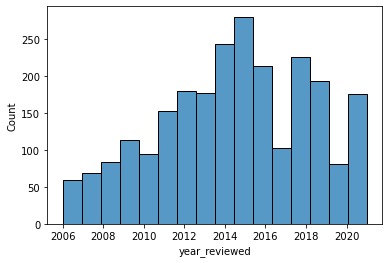

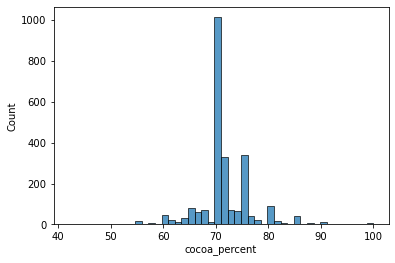

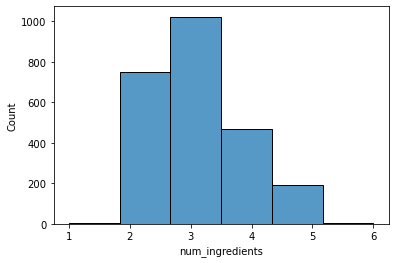

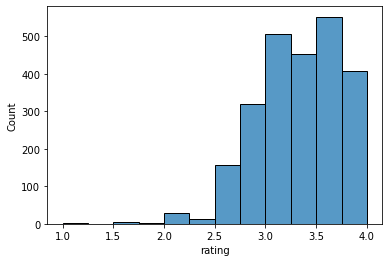

In [11]:
# Show distribution of numerical data
for col in col_num:
    sns.histplot(df_cldl[col], bins = df_cldl[col].nunique())
    plt.show()
    
    

Observations:
- Cacao percent have a accumulation point at 70 %
- Number of ingredients are often 3, 1 and 6 i seldom.
- Ratings have a long left tail.

## Have a look at categorical data

### Clean categorical data

In [12]:
# Explore categorical data

# bean origin is important, explore values
display(np.sort(df_cldl['bean_origin'].unique()))

array(['Australia', 'Belize', 'Blend', 'Bolivia', 'Brazil', 'Burma',
       'Cameroon', 'China', 'Colombia', 'Congo', 'Costa Rica', 'Cuba',
       'DR Congo', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Fiji',
       'Gabon', 'Ghana', 'Grenada', 'Guatemala', 'Haiti', 'Honduras',
       'India', 'Indonesia', 'Ivory Coast', 'Jamaica', 'Liberia',
       'Madagascar', 'Malaysia', 'Martinique', 'Mexico', 'Nicaragua',
       'Nigeria', 'Panama', 'Papua New Guinea', 'Peru', 'Philippines',
       'Principe', 'Puerto Rico', 'Samoa', 'Sao Tome',
       'Sao Tome & Principe', 'Sierra Leone', 'Solomon Islands',
       'Sri Lanka', 'St. Lucia', 'St.Vincent-Grenadines', 'Sulawesi',
       'Sumatra', 'Suriname', 'Taiwan', 'Tanzania', 'Thailand', 'Tobago',
       'Togo', 'Trinidad', 'U.S.A.', 'Uganda', 'Vanuatu', 'Venezuela',
       'Vietnam'], dtype=object)

There are no wrongly written names. 'Sao Tome' belongs to 'Sao Tome & Principe' as does 'Principe'. So I combine them to one value 'Sao Tome & Principe'

In [13]:
df_cldl['bean_origin'] = df_cldl['bean_origin'].replace({'Principe': 'Sao Tome & Principe', 'Sao Tome': 'Sao Tome & Principe'})

# Check replacement
display(np.sort(df_cldl['bean_origin'].unique()))

array(['Australia', 'Belize', 'Blend', 'Bolivia', 'Brazil', 'Burma',
       'Cameroon', 'China', 'Colombia', 'Congo', 'Costa Rica', 'Cuba',
       'DR Congo', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Fiji',
       'Gabon', 'Ghana', 'Grenada', 'Guatemala', 'Haiti', 'Honduras',
       'India', 'Indonesia', 'Ivory Coast', 'Jamaica', 'Liberia',
       'Madagascar', 'Malaysia', 'Martinique', 'Mexico', 'Nicaragua',
       'Nigeria', 'Panama', 'Papua New Guinea', 'Peru', 'Philippines',
       'Puerto Rico', 'Samoa', 'Sao Tome & Principe', 'Sierra Leone',
       'Solomon Islands', 'Sri Lanka', 'St. Lucia',
       'St.Vincent-Grenadines', 'Sulawesi', 'Sumatra', 'Suriname',
       'Taiwan', 'Tanzania', 'Thailand', 'Tobago', 'Togo', 'Trinidad',
       'U.S.A.', 'Uganda', 'Vanuatu', 'Venezuela', 'Vietnam'],
      dtype=object)

In [14]:
# Check names of company location

display(np.sort(df_cldl['company_location'].unique()))

array(['Amsterdam', 'Argentina', 'Australia', 'Austria', 'Belgium',
       'Bolivia', 'Brazil', 'Canada', 'Chile', 'Colombia', 'Costa Rica',
       'Czech Republic', 'Denmark', 'Dominican Republic', 'Ecuador',
       'El Salvador', 'Fiji', 'Finland', 'France', 'Germany', 'Ghana',
       'Grenada', 'Guatemala', 'Honduras', 'Hungary', 'Iceland', 'India',
       'Ireland', 'Israel', 'Italy', 'Japan', 'Lithuania', 'Madagascar',
       'Malaysia', 'Martinique', 'Mexico', 'Netherlands', 'New Zealand',
       'Nicaragua', 'Norway', 'Peru', 'Philippines', 'Poland', 'Portugal',
       'Puerto Rico', 'Russia', 'Sao Tome', 'Sao Tome & Principe',
       'Scotland', 'Singapore', 'South Africa', 'South Korea', 'Spain',
       'St. Lucia', 'St.Vincent-Grenadines', 'Suriname', 'Sweden',
       'Switzerland', 'Taiwan', 'Thailand', 'U.A.E.', 'U.K.', 'U.S.A.',
       'Vanuatu', 'Venezuela', 'Vietnam', 'Wales'], dtype=object)

'Amsterdam' is a city in the 'Netherlands' and 'Sao Tome' belongs to 'Sao Tome & Principe', 'Wales' belongs to 'U.K'. So I correct this:

In [15]:
df_cldl['company_location'] = df_cldl['company_location'].replace({'Amsterdam': 'Netherlands', 'Sao Tome': 'Sao Tome & Principe', 'Wales': 'U.K.'})

# Check replacement
display(np.sort(df_cldl['company_location'].unique()))

array(['Argentina', 'Australia', 'Austria', 'Belgium', 'Bolivia',
       'Brazil', 'Canada', 'Chile', 'Colombia', 'Costa Rica',
       'Czech Republic', 'Denmark', 'Dominican Republic', 'Ecuador',
       'El Salvador', 'Fiji', 'Finland', 'France', 'Germany', 'Ghana',
       'Grenada', 'Guatemala', 'Honduras', 'Hungary', 'Iceland', 'India',
       'Ireland', 'Israel', 'Italy', 'Japan', 'Lithuania', 'Madagascar',
       'Malaysia', 'Martinique', 'Mexico', 'Netherlands', 'New Zealand',
       'Nicaragua', 'Norway', 'Peru', 'Philippines', 'Poland', 'Portugal',
       'Puerto Rico', 'Russia', 'Sao Tome & Principe', 'Scotland',
       'Singapore', 'South Africa', 'South Korea', 'Spain', 'St. Lucia',
       'St.Vincent-Grenadines', 'Suriname', 'Sweden', 'Switzerland',
       'Taiwan', 'Thailand', 'U.A.E.', 'U.K.', 'U.S.A.', 'Vanuatu',
       'Venezuela', 'Vietnam'], dtype=object)

In [16]:
# Split column 'ingrdients' in different columns
# B (Beans), S (Sugar), S* (Sweetener other than sugar or beet sugar), C (Cocoa Butter), (V) Vanilla, (L) Lecithin, Sa (Salt)
# Replace 'S*' with 'W', so that there is no confusion with 'S'
df_cldl['ingredients2'] =df_cldl['ingredients'].str.replace('S*', 'W', regex=False)


for ingredient in ['B', 'S', 'W', 'C', 'V','L', 'Sa']:
    df_cldl[ingredient] = df_cldl['ingredients2'].str.contains(ingredient).astype(int)

In [17]:
# check split ingredients part1
display(df_cldl.head())

,manufacturer,company_location,year_reviewed,bean_origin,cocoa_percent,num_ingredients,ingredients,rating,ingredients2,B,S,W,C,V,L,Sa
0,5150,U.S.A.,2019,Tanzania,76.0,3.0,"B,S,C",3.25,"B,S,C",1,1,0,1,0,0,0
1,5150,U.S.A.,2019,Dominican Republic,76.0,3.0,"B,S,C",3.50,"B,S,C",1,1,0,1,0,0,0
2,5150,U.S.A.,2019,Madagascar,76.0,3.0,"B,S,C",3.75,"B,S,C",1,1,0,1,0,0,0
3,5150,U.S.A.,2021,Fiji,68.0,3.0,"B,S,C",3.00,"B,S,C",1,1,0,1,0,0,0
4,5150,U.S.A.,2021,Venezuela,72.0,3.0,"B,S,C",3.00,"B,S,C",1,1,0,1,0,0,0


In [18]:
# check split ingredients part1
display(df_cldl[df_cldl['W']==True].head())

,manufacturer,company_location,year_reviewed,bean_origin,cocoa_percent,num_ingredients,ingredients,rating,ingredients2,B,S,W,C,V,L,Sa
363,Cacai Cacao,Taiwan,2019,Taiwan,70.0,2.0,"B,S*",3.25,"B,W",1,0,1,0,0,0,0
364,Cacai Cacao,Taiwan,2019,Philippines,70.0,2.0,"B,S*",3.50,"B,W",1,0,1,0,0,0,0
525,Chocolate Alchemist-Philly,U.S.A.,2016,Peru,90.0,2.0,"B,S*",2.50,"B,W",1,0,1,0,0,0,0
526,Chocolate Alchemist-Philly,U.S.A.,2016,Blend,80.0,2.0,"B,S*",2.50,"B,W",1,0,1,0,0,0,0
534,Chocolate Conspiracy,U.S.A.,2014,Peru,74.0,3.0,"B,S*,C",2.75,"B,W,C",1,0,1,1,0,0,0


In [19]:
# Drop ingredients and ingredients2
df_cldlin = df_cldl.drop(['ingredients', 'ingredients2'], axis = 1)

# Check drop
display(df_cldlin.columns)

Index(['manufacturer', 'company_location', 'year_reviewed', 'bean_origin',
       'cocoa_percent', 'num_ingredients', 'rating', 'B', 'S', 'W', 'C', 'V',
       'L', 'Sa'],
      dtype='object')

In [20]:
# To train cleaning data I inspect 'manufacturer', although it is clear, that it is of no use for me, 
# because I want to predict the rating of the new vegan chocolate bar of my start up in Berlin, Germany.
# Check 'manufacturer, if misspellings led to doubled names'
display(df_cldlin['manufacturer'].nunique())


unique_manufacturer = df_cldlin['manufacturer'].unique().tolist()
display(sorted(unique_manufacturer)[:20])

542

['5150',
 'A. Morin',
 'AMMA',
 'Acalli',
 'Adi aka Fijiana (Easy In Ltd)',
 'Aelan',
 'Aequare (Gianduja)',
 'Ah Cacao',
 "Akesson's (Pralus)",
 'Alain Ducasse',
 'Alexandre',
 'Altus aka Cao Artisan',
 'Amano',
 'Amatller (Simon Coll)',
 'Amazona',
 'Ambrosia',
 'Amedei',
 'Anahata',
 'Animas',
 'Ara']

Manufacturers names look clean at first look. Just to try the module I check for similar names with fuzzywuzzy.

In [21]:
# Check for similar manufactures with fuzzywuzzy
from fuzzywuzzy import process, fuzz

#Create tuples of manufacturer names, matched manufacturer names, and the score
score_sort = [(x,) + i
             for x in unique_manufacturer 
             for i in process.extract(x, unique_manufacturer,     scorer=fuzz.token_sort_ratio)]
#Create a dataframe from the tuples
similarity_sort = pd.DataFrame(score_sort, columns=['manufacturer_sort','match_sort','score_sort'])
similarity_sort.head()

,manufacturer_sort,match_sort,score_sort
0,5150,5150,100
1,5150,Park 75,18
2,5150,Cacao 70,17
3,5150,Five (5)Mile,13
4,5150,A. Morin,0


In [22]:
similarity_sort[(similarity_sort['score_sort']>=70)&(similarity_sort['score_sort']<100)]

,manufacturer_sort,match_sort,score_sort
31,Ah Cacao,Beau Cacao,78
32,Ah Cacao,By Cacao,75
33,Ah Cacao,Cacao 70,75
34,Ah Cacao,Cacai Cacao,74
56,Amano,Manoa,80
...,...,...,...
2671,Xocolla,Xocolat,86
2672,Xocolla,Xocolatl,80
2701,Zoto (Chocolatoa),Chocolatoa,80
2702,Zoto (Chocolatoa),Hotel Chocolat,76


The manufacturers names look clean, no similarities, therefor no misspelling.

### Look at distributions of categorical data

In [23]:
# Defince categorical columns
col_cat_long = ['manufacturer', 'company_location', 'bean_origin']
col_cat_ing = ['B', 'S', 'W', 'C', 'V',
       'L', 'Sa']

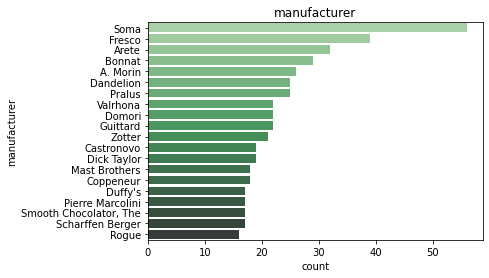

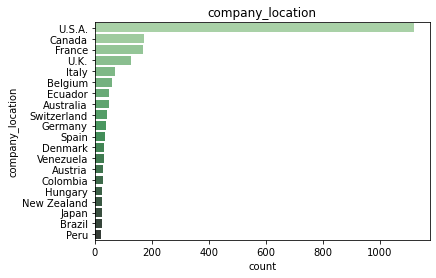

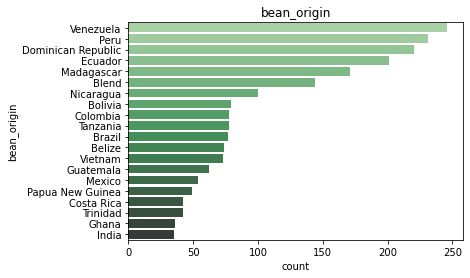

In [24]:
# 'Manufacturer', 'company_location', 'bean_orgin' have many values, so I concentrate on the most frequent ones

for col in col_cat_long:
    sns.countplot(y=col, data=df_cldlin, palette= 'Greens_d',
              order=df_cldlin[col].value_counts().iloc[:20].index)
    plt.title(col)
    plt.show()

The distribution are all skewed. The most frequent manufacturer is 'Soma' and most companies are located in the U.S.A.. The bean_origin is concentrated on the coutries Venezuela, Peru, Domincian Republic, Ecuador and Madagascar.

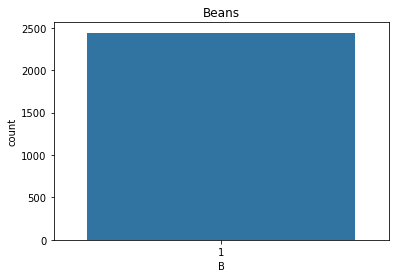

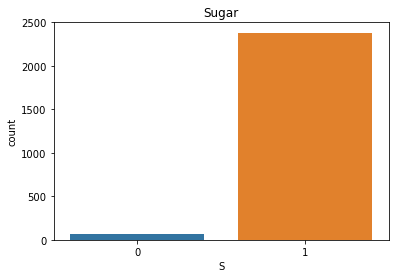

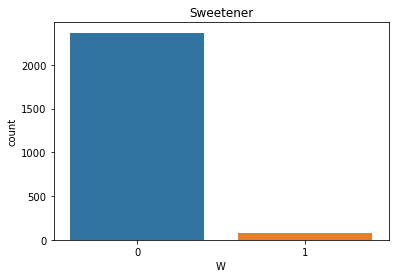

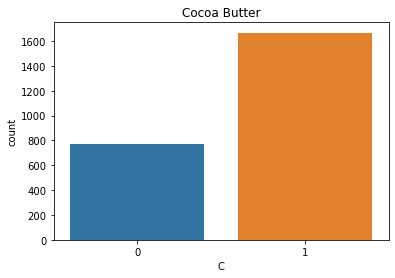

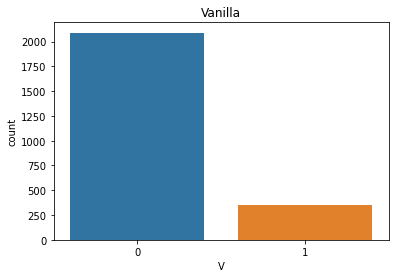

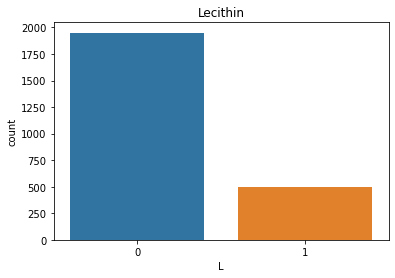

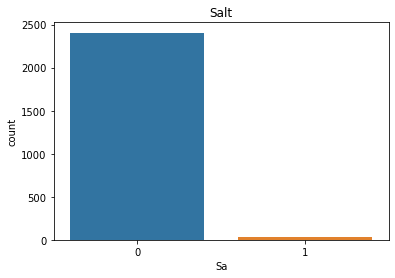

In [25]:
col_ingr_names = {'B': 'Beans', 'S': 'Sugar', 'W': 'Sweetener', 'C': 'Cocoa Butter', 'V': 'Vanilla', 'L': 'Lecithin', 'Sa' :'Salt'}

for col in col_cat_ing:
    sns.countplot(x=df_cldlin[col])
    plt.title(col_ingr_names[col])
    plt.show()

The ingredient bean is in every choclate bar, which is clear. So the ingredient bean has no influence to the rating, only the origin of the beans. Sugar is used often, where as Sweetener is used in only a few chocolate bars. It is no surprise, that Cocoa Butter is used often. It is interesting to explore if the rating of bars is worse if no Cacoa Butter is used. Vanilla and Lecithin are used about in every 5th Chocolate bar and Salt only seldom. It is interesting if Vanilla, Lecithin or Salt have an influcence on the rating.

## Bivariate Distribution

### Numerical Data compared to target rating

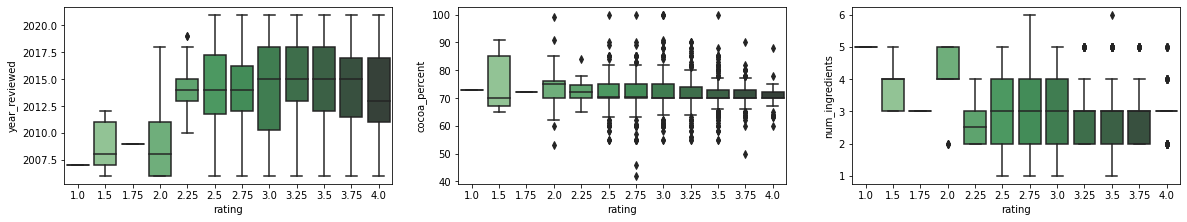

In [26]:
fig = plt.figure(figsize=(20,15))
j = 1

for col in col_num_ot:
    sub = fig.add_subplot(4, 3, j)
    chart = sns.boxplot(x = 'rating', y = col, palette='Greens_d', data= df_cldlin);
    j = j +1 
    
plt.show()

It looks like the poor ratings were the years between 2007 to 2010. The cacoa percent seems not to have much impact. There seem to be a little influence that fewer ingredients lead to poorer ratings. 

### Categorcial data compared to rating

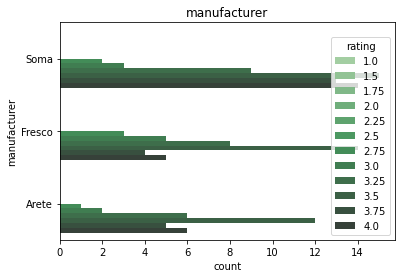

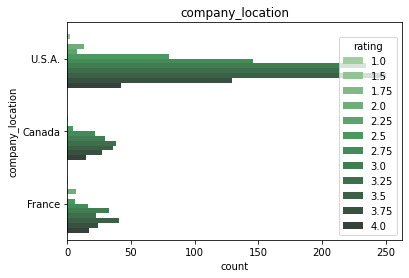

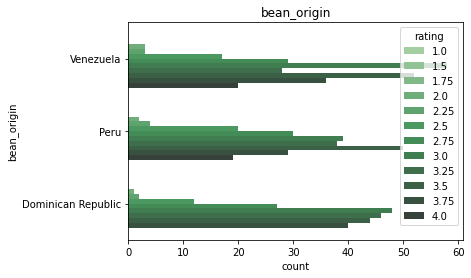

In [27]:
# 'Manufacturer', 'company_location', 'bean_orgin' have many values, so I concentrate on the most frequent ones

for col in col_cat_long:
    sns.countplot(y=col, data=df_cldlin, hue='rating', palette="Greens_d",
              order=df_cldlin[col].value_counts().iloc[:3].index)
    plt.title(col)
    plt.show()

It looks like the manufacterer Soma has a lot of good ratings, the ratings per country look normally distributed. Beans from the Dominican Repuclic seem to lead to good ratings.

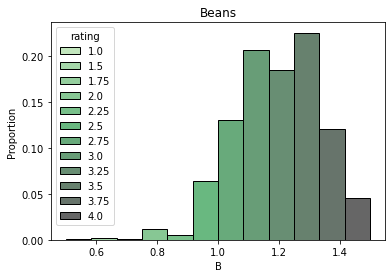

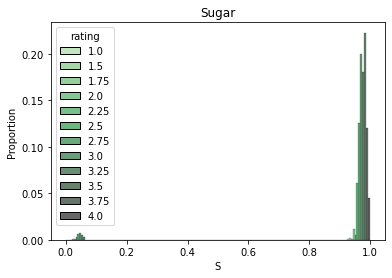

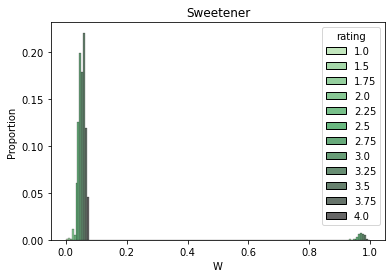

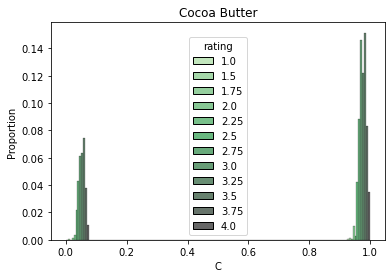

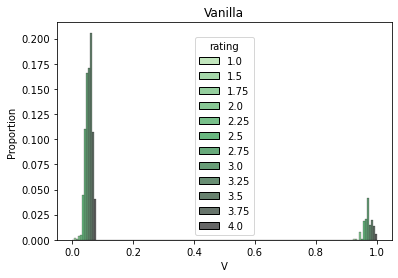

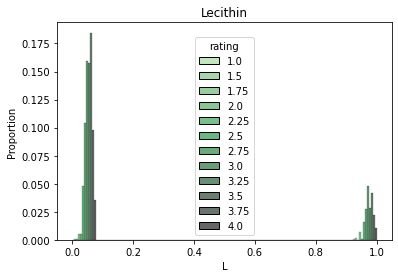

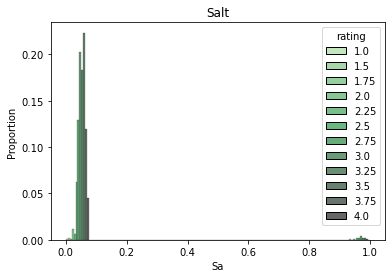

In [28]:
for col in col_cat_ing:
    sns.histplot(x=col, hue = 'rating', stat='proportion', palette="Greens_d",multiple='dodge', data=df_cldlin)
    plt.title(col_ingr_names[col])
    plt.show()

It seems like the ingredients sugar and caoca butter lead to better ratings whereas Sweetener, Vanilla, Lecithin and Salt got poor ratings.

## Explore the correlations

### Correlations with numerical columns

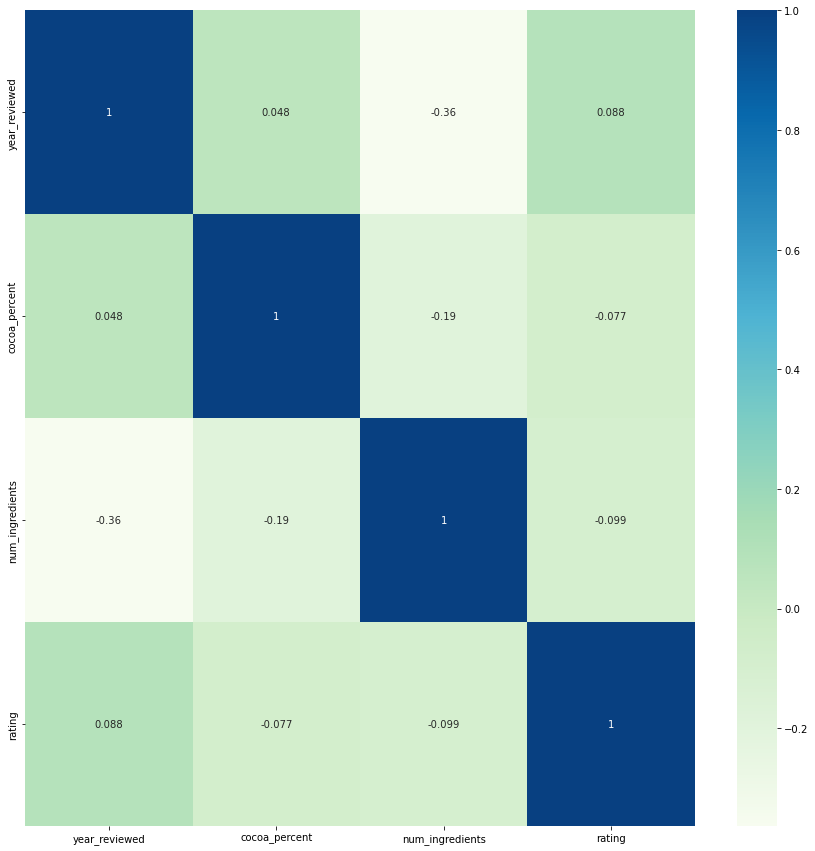

In [29]:
plt.figure(1,figsize=(15,15))
correlation = df_cldlin[col_num].corr()
sns.heatmap(correlation, cmap='GnBu', annot = True);

The numerical data is not correlated as expected.

### Correlation of Ingredients

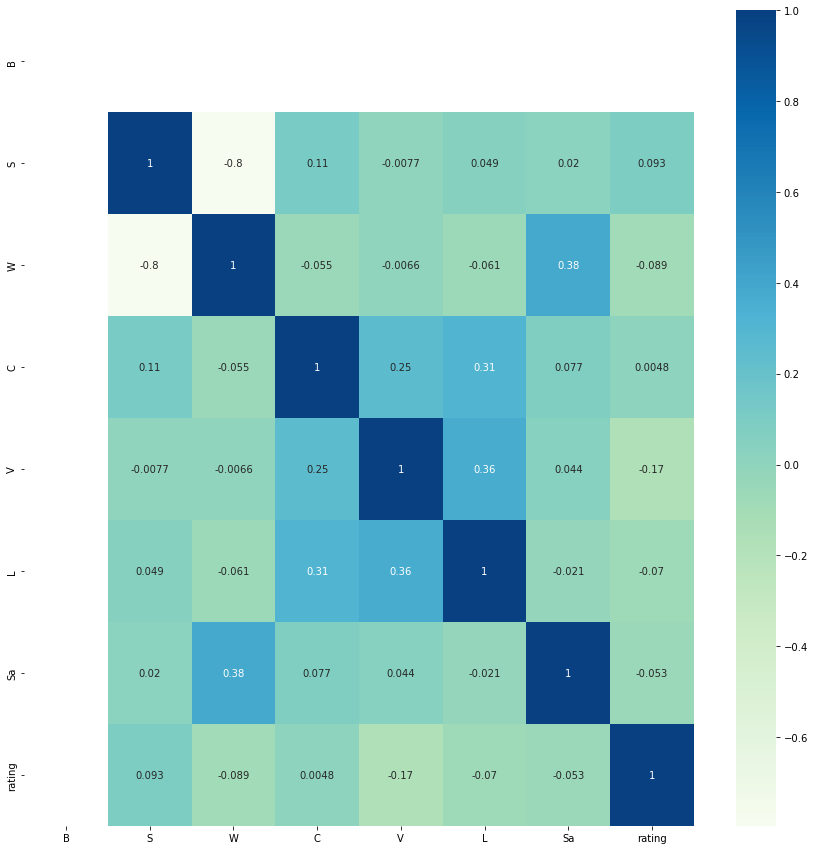

In [30]:
plt.figure(1,figsize=(15,15))

correlation = df_cldlin[col_cat_ing+ ['rating']].corr()
sns.heatmap(correlation, cmap='GnBu', annot = True);

Sugar and Sweetener are correlated, which is plausible, because, when there is sugar there is no sweetener in the chocolate bar and vice versa. So one of both is sufficient for regression. The other ingredients are not correlated.

### Correlation of the categorical data

The columns  'manufacturer', 'company_location', 'bean_origin' have to be transformed in order to caculate the correlation. Because the have very much values I only use the most frequent 5 values. 

In [31]:
categorical = {}
col_cat_long_tf = []

for c in col_cat_long:
    categorical[c] = list(df_cldlin[c].value_counts().head(10).index)

for name, values in categorical.items():
    for value in values:
        df_cldlin['%s_%s' % (name, value)] = (df_cldlin[name] == value).astype(int)
        col_cat_long_tf.append('%s_%s' % (name, value))
  
# Check the transformation
display(col_cat_long_tf)      


['manufacturer_Soma',
 'manufacturer_Fresco',
 'manufacturer_Arete',
 'manufacturer_Bonnat',
 'manufacturer_A. Morin',
 'manufacturer_Dandelion',
 'manufacturer_Pralus',
 'manufacturer_Valrhona',
 'manufacturer_Domori',
 'manufacturer_Guittard',
 'company_location_U.S.A.',
 'company_location_Canada',
 'company_location_France',
 'company_location_U.K.',
 'company_location_Italy',
 'company_location_Belgium',
 'company_location_Ecuador',
 'company_location_Australia',
 'company_location_Switzerland',
 'company_location_Germany',
 'bean_origin_Venezuela',
 'bean_origin_Peru',
 'bean_origin_Dominican Republic',
 'bean_origin_Ecuador',
 'bean_origin_Madagascar',
 'bean_origin_Blend',
 'bean_origin_Nicaragua',
 'bean_origin_Bolivia',
 'bean_origin_Colombia',
 'bean_origin_Tanzania']

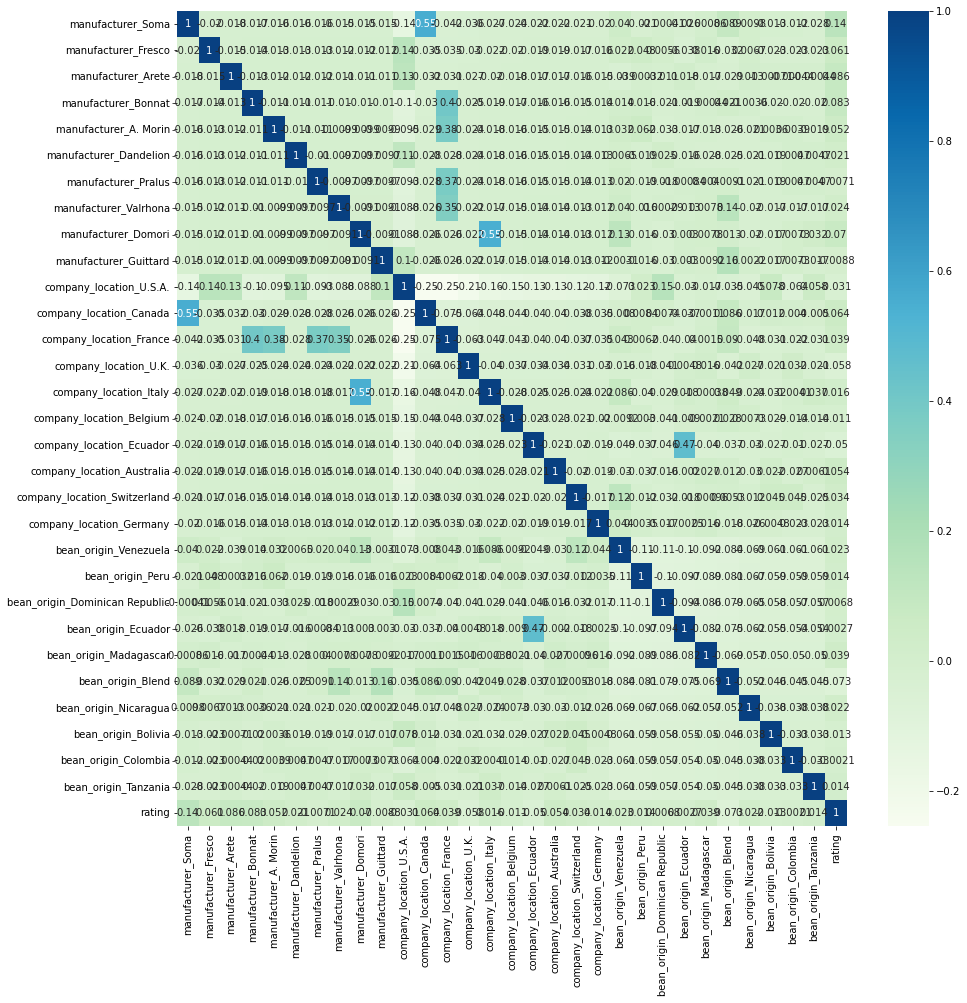

In [32]:
plt.figure(1,figsize=(15,15))

correlation = df_cldlin[col_cat_long_tf+ ['rating']].corr()
sns.heatmap(correlation, cmap='GnBu', annot = True);

There are, of course, correlations beetween manufacturer and company_locaton. So it is interesting to explore of one of them is sufficent as feature in regression, if I would be interested in the influence of the manufacturer. Since I want to predict ratings from a new company. I will not use  this feature.

## Compare models in baseline approach and decide for one model

In the baseline approache I concentrate on the numeric columns. After deciding for one, I try the categorical data.

In [33]:
# Choose features and target

# features
X = df_cldlin[col_num_ot]
# target
y = df_cldlin['rating']

# Set seed
seed = 42
np.random.seed(seed)

# Split data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Scale data (has impact on Linear Regression not Decision Tree)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {"Linear Regression": LinearRegression(), "Decision Tree": DecisionTreeRegressor(), 
              "Random Forest": RandomForestRegressor() }

In [34]:
# Compare models
results = []
for model in models.values():
    kf = KFold(n_splits=6, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, scoring='neg_root_mean_squared_error', cv=kf)
    results.append(cv_results)

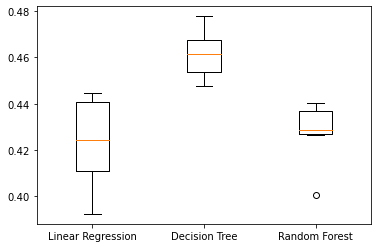

In [35]:
# Apply abs() on negative values
results_abs = [abs(i) for i in results]

# Show results
plt.boxplot(results_abs, labels=models.keys())
plt.show()

The results show that the mean of LinearRegression is slighly better then RandomForest, where as the variance of Radom Forest ist much better. So Random Forest seems to be the better model. I see if it the same with the test set performance.

In [36]:
# Test Set Performance
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    print("{} Test Set Score: {}".format(name, test_score))


Linear Regression Test Set Score: 0.02546466124549951
Decision Tree Test Set Score: -0.1089882731053835
Random Forest Test Set Score: -0.0017207872603399732


Random Forest is here slightly better, so I decide on RandomForest as the best modell.

## Hyperparameter tuning for Random Forest

To find the best parameter for RandomForest I do GridSearch

In [37]:
# Define cross-validation
kf = KFold(n_splits = 6, shuffle = True, random_state =seed)
# Define parameters
param_grid ={'n_estimators': [100, 200, 300, 400, 500],
                'max_depth' : [4, 6, 8],
                'min_samples_leaf' :[0.01, 0.02], 
                'max_features' : ['log2', 'sqrt']}

# Define model
rf = RandomForestRegressor()

In [38]:
# Do Search
rf_cv = GridSearchCV(rf, param_grid, cv = kf)
rf_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=KFold(n_splits=6, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 6, 8],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [0.01, 0.02],
                         'n_estimators': [100, 200, 300, 400, 500]})

In [39]:
# Print result
display('Results of GridSearch: ', rf_cv.best_params_, rf_cv.best_score_, rf_cv.best_estimator_)


'Results of GridSearch: '

{'max_depth': 8,
 'max_features': 'log2',
 'min_samples_leaf': 0.01,
 'n_estimators': 100}

0.05775638868775048

RandomForestRegressor(max_depth=8, max_features='log2', min_samples_leaf=0.01)

In [40]:
test_score = rf_cv.score(X_test_scaled, y_test)
print(test_score)

0.05269117643784471


## Explore feature performance and categorical data

In [41]:
# Train best model

rf = RandomForestRegressor(max_depth=8, max_features='log2', min_samples_leaf=0.01)

rf.fit(X_train_scaled,y_train)

RandomForestRegressor(max_depth=8, max_features='log2', min_samples_leaf=0.01)

In [42]:
# Evaluate on test data

y_pred = rf.predict(X_test_scaled)
mse = MSE(y_test, y_pred)
rmse = mse **(1/2)

display('MSE: ', mse, 'RMSE:', rmse)


'MSE: '

0.1789505060223318

'RMSE:'

0.42302542006637356

The RMSE is nearly the RMSE form model selection. So the model is okay.

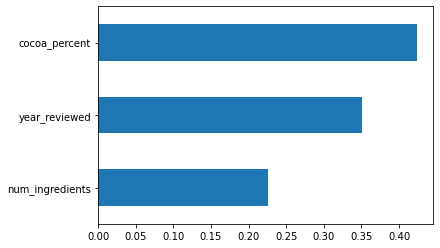

In [43]:
# Look at importance of features of baseline

importance_rf = pd.Series(rf.feature_importances_, index = X.columns)
sorted_importance_rf = importance_rf.sort_values()
sorted_importance_rf.plot(kind='barh');


Cocao_percent hat more importance than num_ingredients. On the year of the review I have no influence with my new chocolate bar, but it was obvious that in older reviews the ratings were poorer.

### Check the ingredients


In [44]:
# Define function to test on different feature samples

def do_feature_test(X, y):    
    '''   
       Description: do_model_test_evaluate bundles the split of the data in training in test, the scaler,
       the fit of the model and the calculation of the rmse
       Input: The dataframe that contains the features
       Output: Rmse for this feature-set.
       Use: local use, so that I do not have to multiply code, to test the performance of different feature-sets.
     '''

    # Split data set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    # Scale data (has impact on Linear Regression not Decision Tree)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    #Fit_model
    rf.fit(X_train_scaled, y_train)
    y_pred = rf.predict(X_test_scaled)
    mse = MSE(y_test, y_pred)
    rmse = mse**(1/2)
    
    return rmse
    
    

In [45]:
# Select ingredient columm
col_cat_ing_imp =  ['S',  'C', 'V', 'L', 'Sa']
base = col_num_ot
results={}

for col in col_cat_ing_imp:
    features = base + [col]
    X = df_cldlin[features]
    rmse=do_feature_test(X, y)
    results[col]=rmse   
    

display(results)

{'S': 0.42050463417187206,
 'C': 0.42282150446619376,
 'V': 0.4213151040897779,
 'L': 0.42169045265055577,
 'Sa': 0.42253141716347903}

The ingredients improve the models slight. The most impact has Vanilla 'V'. Salt 'Sa' makes no difference.

### Check performance of model with ingrediens

'Rmse with ingredients:'

0.41971564925682364

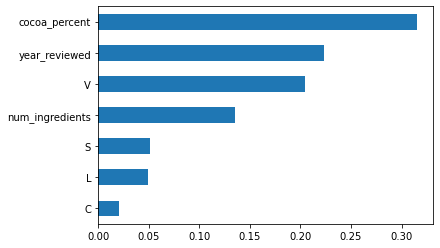

In [46]:
# I add the ingredients beside Salt 'Sa' to the features
base_ing = col_num_ot + ['S',  'C', 'V', 'L']
features = base_ing   
X = df_cldlin[features]

# Calculate Score
rmse=do_feature_test(X, y)
display('Rmse with ingredients:', rmse)
    
#Display importance of features
importance_rf = pd.Series(rf.feature_importances_, index = X.columns)
sorted_importance_rf = importance_rf.sort_values()
sorted_importance_rf.plot(kind='barh')
plt.show()

### Check the origin of the beans

In [47]:
# I add the ingredients beside Salt 'Sa' to the features
base_ing = col_num_ot + ['S',  'C', 'V', 'L']
# Define origin columns
col_origins = ['bean_origin_Venezuela', 'bean_origin_Peru', 'bean_origin_Dominican Republic',
                 'bean_origin_Ecuador', 'bean_origin_Madagascar', 'bean_origin_Blend',
                 'bean_origin_Nicaragua', 'bean_origin_Bolivia', 'bean_origin_Colombia',
                 'bean_origin_Tanzania']
results={}

for col in col_origins:
    features = base_ing + [col]
    X = df_cldlin[features]
    rmse=do_feature_test(X, y)
    results[col]=rmse   
    

display(results)


{'bean_origin_Venezuela': 0.41958618539769266,
 'bean_origin_Peru': 0.4186406949164009,
 'bean_origin_Dominican Republic': 0.41987402005175434,
 'bean_origin_Ecuador': 0.41957739569727687,
 'bean_origin_Madagascar': 0.41894832891594597,
 'bean_origin_Blend': 0.42084145490112074,
 'bean_origin_Nicaragua': 0.42013847189014375,
 'bean_origin_Bolivia': 0.41880004822103,
 'bean_origin_Colombia': 0.41864916474914415,
 'bean_origin_Tanzania': 0.41856633809943705}

In [48]:
# Getting min of rmse
min_rmse_origins = min(results.values())
min_origins = [key for key in results if results[key] == min_rmse_origins]
display('RMSE is minimum for origin:', min_origins, 'RMSE:', min_rmse_origins)

'RMSE is minimum for origin:'

['bean_origin_Tanzania']

'RMSE:'

0.41856633809943705

### Check performance of model with all features

'Rmse with ingredients:'

0.42143843277452075

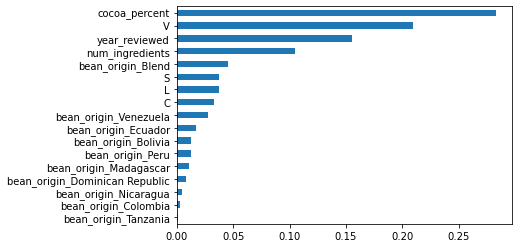

In [49]:
# I add the ingredients beside Salt 'Sa' to the features
features = base_ing + col_origins
X = df_cldlin[features]

# Calculate Score
rmse=do_feature_test(X, y)
display('Rmse with ingredients:', rmse)
    
#Display importance of features
importance_rf = pd.Series(rf.feature_importances_, index = X.columns)
sorted_importance_rf = importance_rf.sort_values()
sorted_importance_rf.plot(kind='barh')
plt.show()

## Predict rating for new chocolate bar

I create four versions of the new chocolate bar and predict the ratings:
 - Bar1: 70 % Kakao, Ingredients: BSC, Origin: Venezuela
 - Bar2: 80 % Kakao, Ingredients: BSCV, Origin: Blend
 - Bar3: 90 % Kakao, Ingredients: BSCL, Origin: Bolivia
 - Bar4: 70 % Kakao, Ingredients: BSCV, Origin: Blend

In [73]:
# Now, I have a model to predict the ratings of the four versions of my new chocolate bar

bar4=[]

bar1 = [2022, 70,3,1,1,0,0,1,0,0,0,0,0,0,0,0,0]
bar2 = [2022, 80,4,1,1,1,0,0,0,0,0,0,1,0,0,0,0]
bar3 = [2022, 90,4,1,1,0,1,0,0,0,0,0,0,0,1,0,0]
bar4 = [2022, 70,4,1,1,1,0,0,0,0,0,0,1,0,0,0,0]

#Construct dataframe out of bars
bars_stack = np.vstack([bar1,bar2, bar3, bar4])

df_bars_with_names = pd.DataFrame(bars_stack,columns=features)
df_bars = pd.DataFrame(bars_stack)

#Check construct
display(df_bars_with_names)

display(df_bars)

,year_reviewed,cocoa_percent,num_ingredients,S,C,V,L,bean_origin_Venezuela,bean_origin_Peru,bean_origin_Dominican Republic,bean_origin_Ecuador,bean_origin_Madagascar,bean_origin_Blend,bean_origin_Nicaragua,bean_origin_Bolivia,bean_origin_Colombia,bean_origin_Tanzania
0,2022,70,3,1,1,0,0,1,0,0,0,0,0,0,0,0,0
1,2022,80,4,1,1,1,0,0,0,0,0,0,1,0,0,0,0
2,2022,90,4,1,1,0,1,0,0,0,0,0,0,0,1,0,0
3,2022,70,4,1,1,1,0,0,0,0,0,0,1,0,0,0,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,2022,70,3,1,1,0,0,1,0,0,0,0,0,0,0,0,0
1,2022,80,4,1,1,1,0,0,0,0,0,0,1,0,0,0,0
2,2022,90,4,1,1,0,1,0,0,0,0,0,0,0,1,0,0
3,2022,70,4,1,1,1,0,0,0,0,0,0,1,0,0,0,0


In [74]:
# Transform df_bars
df_bars_tf = df_bars_with_names.copy()
df_bars_tf[col_num_ot] = scaler.transform(df_bars_with_names[col_num_ot])


display(df_bars_tf)

,year_reviewed,cocoa_percent,num_ingredients,S,C,V,L,bean_origin_Venezuela,bean_origin_Peru,bean_origin_Dominican Republic,bean_origin_Ecuador,bean_origin_Madagascar,bean_origin_Blend,bean_origin_Nicaragua,bean_origin_Bolivia,bean_origin_Colombia,bean_origin_Tanzania
0,1.881729,-0.289054,-0.028028,1,1,0,0,1,0,0,0,0,0,0,0,0,0
1,1.881729,1.653547,1.067287,1,1,1,0,0,0,0,0,0,1,0,0,0,0
2,1.881729,3.596147,1.067287,1,1,0,1,0,0,0,0,0,0,0,1,0,0
3,1.881729,-0.289054,1.067287,1,1,1,0,0,0,0,0,0,1,0,0,0,0


In [75]:
# Predict Ratings of bars
y_pred = rf.predict(df_bars_tf)

display(y_pred)

C:\Users\loren\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


array([3.27249776, 3.12240139, 3.11806052, 3.21727421])

So, my new bar in version 1 is predicted to have the best ratings. Though, they are all not this good. Maybe it is because the manufacturer is a start-up in Germany. If I would include manufacturer in the model, maybe I would be the manufacturer Soma I would be able to create a bar with a rating of 5.